In [1]:
from pycaret.datasets import get_data
from pycaret.classification import ClassificationExperiment

from sklearnex import patch_sklearn
from daal4py.oneapi import sycl_context
# patch_sklearn()

%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.regression import *
from hossam.plot import *
from hossam.tensor import *
from hossam.analysis import *
from hossam.classification import *
from pandas import merge, read_excel, pivot_table, melt, to_datetime, to_timedelta, DateOffset, Timestamp, Period, Series
import numpy as np
import re
import numpy as np

# 로지스틱 회귀 통계 모형
from statsmodels.api import Logit, add_constant
# 확률밀도함수
from scipy.stats import norm
from datetime import datetime

ModuleNotFoundError: No module named 'pycaret'

In [83]:

data = my_read_excel("통합11-2.xlsx", info=False)
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.drop(['잔여개월수'], axis=1, inplace=True)
data.drop(['회원카드번호'], axis=1, inplace=True)
data.drop(['매출액2'], axis=1, inplace=True)
data.drop(['상환액매출'], axis=1, inplace=True)
data.drop(['매출액'], axis=1, inplace=True)
tmp = data.select_dtypes('object')
tmp_column=list(tmp.columns)
# data.loc[:,tmp_column] = data.loc[:,tmp_column].astype('category')
# data.info()


상위 5개 행
+----+--------------+----------------+---------+----------+----------+------------+------------+--------+--------------+------------+------------+--------+------------+------------+--------+----------+------------+--------+------------------+------------+----------+------------+------------+------------+------------+------------+----------+----------------+----------------+--------------+----------------+------------------+------------+------------+----------+--------------+--------------+--------------+-----------+------------+-----------------+------------+------------+------------------+------------------+----------+---------------------+----------+------+--------+------------+-----------+
|    |   Unnamed: 0 |   회원카드번호 | 연월    | 등록명   |   개월수 | 종료시점   |   환불여부 |   양도 |   잔여개월수 |   결제시점 |   이탈여부 |   광고 |     추세값 |   환불내역 | 요일   |   미수액 |   일일입장 |   분실 |   부가서비스사용 |   레슨여부 |   매출액 |   골프전환 |   단체회원 |   골프매출 |   라카매출 |   헬스매출 |   PT매출 |   골프레슨매출 |   일일입장매출 |   양도비매출 |   필라테스매

In [84]:
data.loc[data['환불내역'].isna(), '환불내역']=""
data.loc[data['트레이너'].isna(), '트레이너']=""
for i in range(len(data)):
    data.loc[i, '요일']= data.loc[i, '거래일'].day_name()

In [ ]:
labelled_data =my_labelling(data, *tmp_column)

In [89]:
tmp_column

['연월',
 '등록명',
 '종료시점',
 '환불내역',
 '요일',
 '트레이너',
 ['연월',
  '등록명',
  '환불여부',
  '양도',
  '이탈여부',
  '환불내역',
  '요일',
  '일일입장',
  '분실',
  '부가서비스사용',
  '레슨여부',
  '골프전환',
  '단체회원',
  'FC 성별',
  '트레이너',
  '트레이너 성별',
  '월',
  '분기']]

In [90]:
tmp_column =['연월', '등록명', '환불여부', '양도', '이탈여부','환불내역', '요일', '일일입장', '분실', '부가서비스사용', '레슨여부', '골프전환','단체회원','FC 성별', '트레이너', '트레이너 성별', '월', '분기']

['연월',
 '등록명',
 '환불여부',
 '양도',
 '이탈여부',
 '환불내역',
 '요일',
 '일일입장',
 '분실',
 '부가서비스사용',
 '레슨여부',
 '골프전환',
 '단체회원',
 'FC 성별',
 '트레이너',
 '트레이너 성별',
 '월',
 '분기']

In [91]:
data_dum =my_dummies(labelled_data, *tmp_column)

In [111]:
data = data_dum.copy()

In [96]:
data.describe()

,개월수,종료시점,결제시점,광고,추세값,미수액,골프매출,라카매출,헬스매출,PT매출,...,월_6,월_7,월_8,월_9,월_10,월_11,월_12,분기_2,분기_3,분기_4
count,6309.000000,6309.000000,6309.000000,6309.000000,6309.000000,6.309000e+03,6.309000e+03,6309.000000,6.309000e+03,6.309000e+03,...,6309.000000,6309.000000,6309.000000,6309.000000,6309.000000,6309.000000,6309.000000,6309.000000,6309.000000,6309.000000
mean,7.867015,44.845142,-0.456966,0.378507,0.032222,5.355099e+04,3.414684e+05,70258.440323,4.995473e+05,2.811437e+05,...,0.078459,0.081946,0.067998,0.065938,0.073704,0.106673,0.068949,0.243779,0.215882,0.249326
std,5.908591,15.876973,4.184580,0.485053,1.396916,4.468039e+05,7.144089e+05,96105.463682,1.271306e+06,1.037132e+06,...,0.268914,0.274305,0.251763,0.248193,0.261310,0.308722,0.253388,0.429395,0.411465,0.432657
min,-24.000000,0.000000,-45.000000,0.000000,-16.000000,-3.300000e+06,-2.028000e+06,-360000.000000,-2.178000e+06,-3.300000e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,32.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,45.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,60000.000000,3.300000e+05,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.000000,59.000000,0.000000,1.000000,0.000000,0.000000e+00,7.000000e+05,120000.000000,9.900000e+05,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,24.000000,81.000000,22.000000,1.000000,23.000000,2.960000e+07,3.788000e+06,540000.000000,4.500000e+07,1.562500e+07,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [112]:
data =data.fillna(0)
data =data.drop(['거래일'], axis=1)
data =data.drop(['환불일'], axis=1)

In [115]:
data['이탈여부_1'].value_counts()

1    3577
0    2732
Name: 이탈여부_1, dtype: int64

In [113]:
x_train, x_test, y_train, y_test = my_train_test_split(data, "이탈여부_1", scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5047, 174), (1262, 174), (5047,), (1262,))

가지치기를 하지 않습니다.


[교차검증 TOP5]
+----+-------------+--------------+-------------+----------------+--------------------+-------------+-----------------+---------+--------------------+-------------------+
|    |   subsample |   reg_lambda |   reg_alpha |   n_estimators |   min_child_weight |   max_depth |   learning_rate |   gamma |   colsample_bytree |   mean_test_score |
|----+-------------+--------------+-------------+----------------+--------------------+-------------+-----------------+---------+--------------------+-------------------|
|  0 |           1 |            5 |           1 |            300 |                  9 |           6 |             0.5 |       3 |                0.7 |          0.789377 |
|  1 |           1 |            7 |           1 |            200 |                  1 |           6 |             0.1 |       2 |                0.7 |          0.786998 |
|  2 |         0.5 |            9 |           1 |            100 |                  3 |           4 |             0.1 |       2 |    

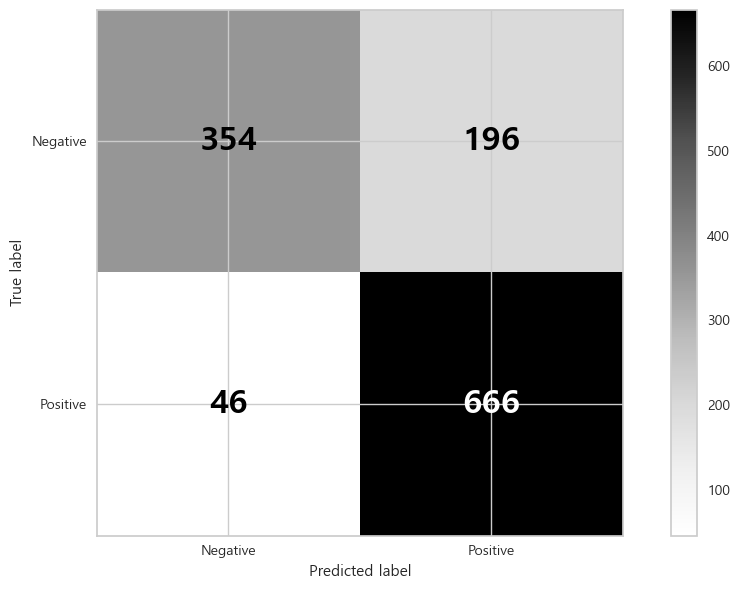


[변수 중요도]


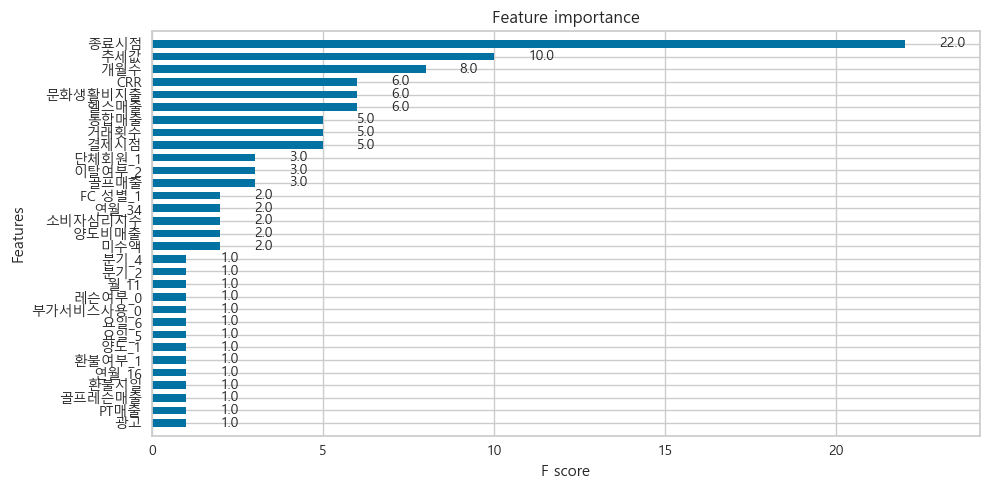

+------------------+---------+------------+----------+
|                  |   score |       rate |   cumsum |
|------------------+---------+------------+----------|
| 종료시점         |      22 |   0.207547 | 0.207547 |
| 추세값           |      10 |  0.0943396 | 0.301887 |
| 개월수           |       8 |  0.0754717 | 0.377358 |
| 헬스매출         |       6 |  0.0566038 | 0.433962 |
| 문화생활비지출   |       6 |  0.0566038 | 0.490566 |
| CRR              |       6 |  0.0566038 |  0.54717 |
| 결제시점         |       5 |  0.0471698 |  0.59434 |
| 거래횟수         |       5 |  0.0471698 | 0.641509 |
| 통합매출         |       5 |  0.0471698 | 0.688679 |
| 골프매출         |       3 |  0.0283019 | 0.716981 |
| 단체회원_1       |       3 |  0.0283019 | 0.745283 |
| 이탈여부_2       |       3 |  0.0283019 | 0.773585 |
| FC 성별_1        |       2 |  0.0188679 | 0.792453 |
| 미수액           |       2 |  0.0188679 | 0.811321 |
| 연월_34          |       2 |  0.0188679 | 0.830189 |
| 소비자심리지수   |       2 |  0.0188679 | 0.849057 |
| 양도비매출       

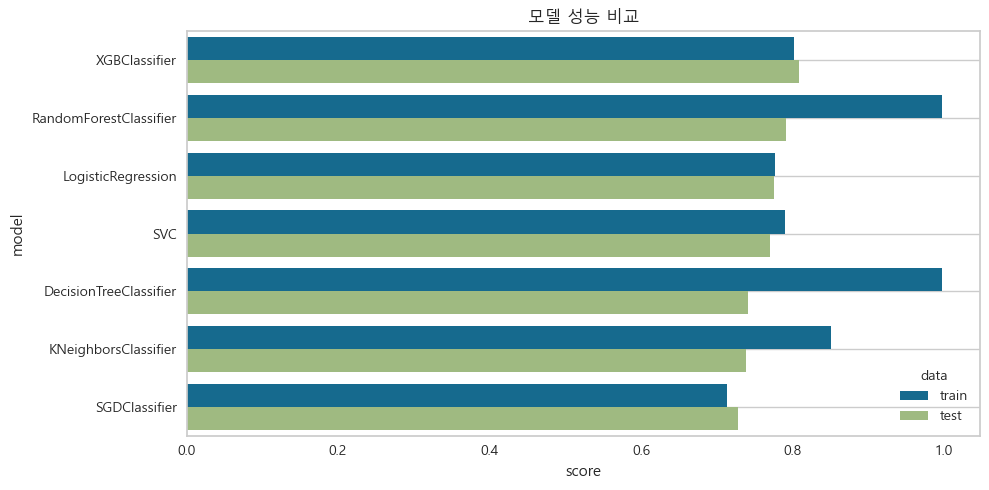



[분류분석 성능평가]========= 최고 성능 모델: XGBClassifier ====================
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.801862 |     0.808241 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.765443 |     0.772622 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.938569 |     0.935393 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |     0.377635 |     0.356364 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.622365 |     0.643636 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.843211 |     0.846252 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.884941 |     0.8

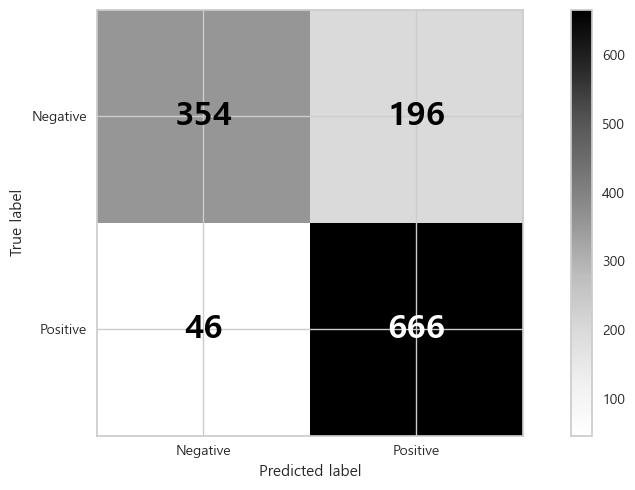


[변수 중요도]


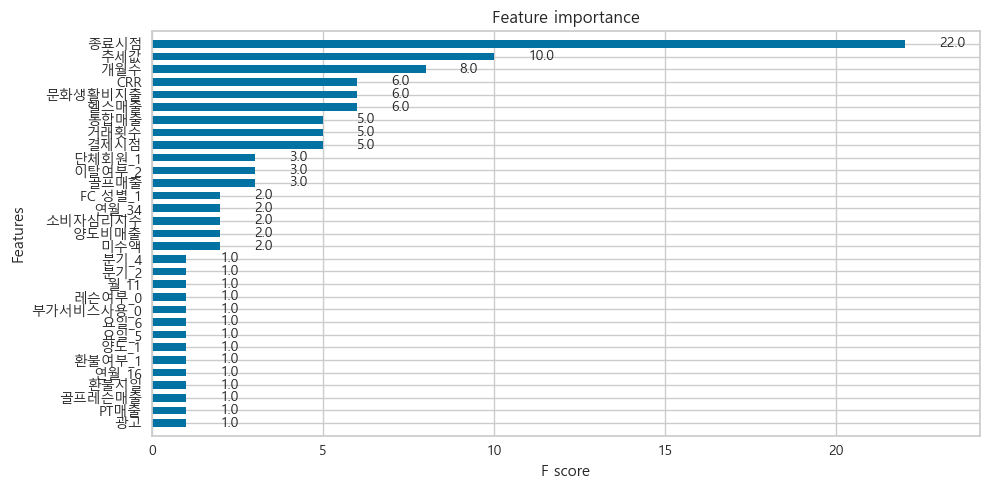

+------------------+---------+------------+----------+
|                  |   score |       rate |   cumsum |
|------------------+---------+------------+----------|
| 종료시점         |      22 |   0.207547 | 0.207547 |
| 추세값           |      10 |  0.0943396 | 0.301887 |
| 개월수           |       8 |  0.0754717 | 0.377358 |
| 헬스매출         |       6 |  0.0566038 | 0.433962 |
| 문화생활비지출   |       6 |  0.0566038 | 0.490566 |
| CRR              |       6 |  0.0566038 |  0.54717 |
| 결제시점         |       5 |  0.0471698 |  0.59434 |
| 거래횟수         |       5 |  0.0471698 | 0.641509 |
| 통합매출         |       5 |  0.0471698 | 0.688679 |
| 골프매출         |       3 |  0.0283019 | 0.716981 |
| 단체회원_1       |       3 |  0.0283019 | 0.745283 |
| 이탈여부_2       |       3 |  0.0283019 | 0.773585 |
| FC 성별_1        |       2 |  0.0188679 | 0.792453 |
| 미수액           |       2 |  0.0188679 | 0.811321 |
| 연월_34          |       2 |  0.0188679 | 0.830189 |
| 소비자심리지수   |       2 |  0.0188679 | 0.849057 |
| 양도비매출       

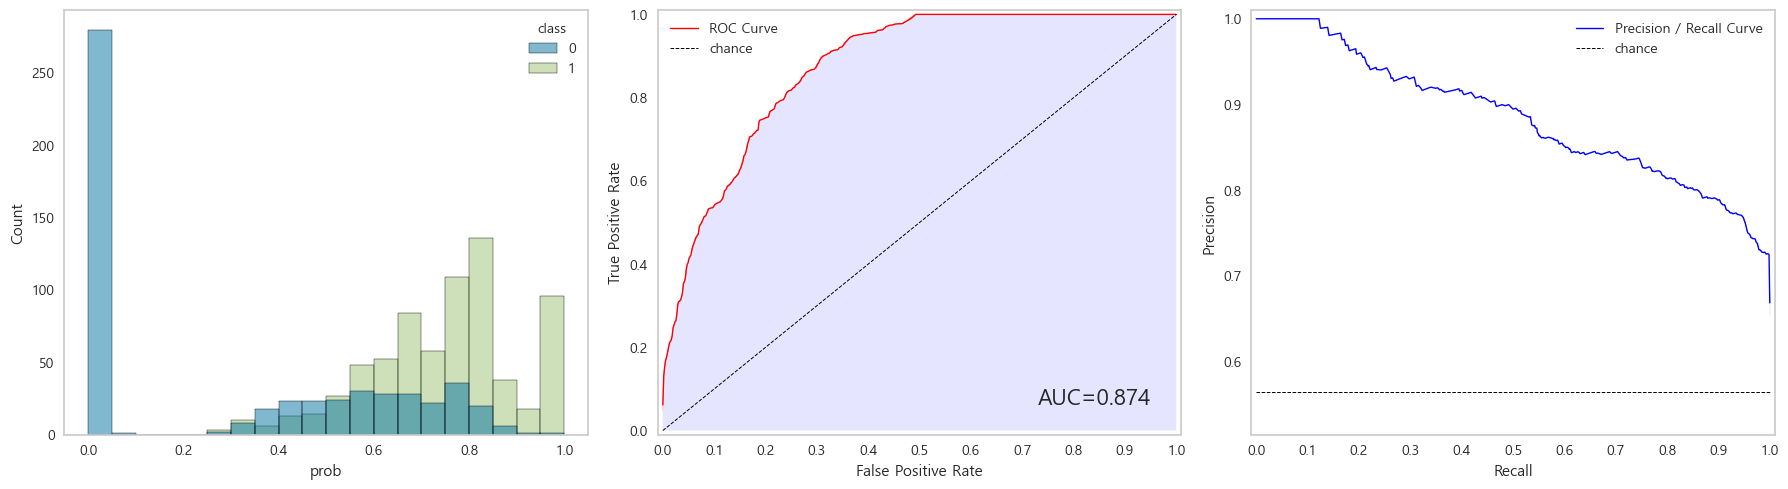


[학습곡선]


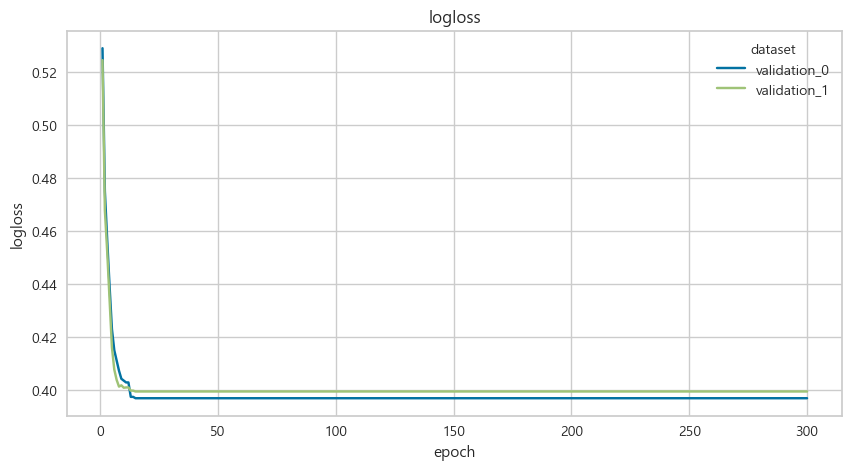

+-----+---------+------------+-------------------+-------------+
|     |   index | 종속변수   | 독립변수          |         VIF |
|-----+---------+------------+-------------------+-------------|
|   0 |     173 | 이탈여부_1 | 분기_4            |         inf |
|   1 |      61 | 이탈여부_1 | 연월_36           |         inf |
|   2 |      59 | 이탈여부_1 | 연월_34           |         inf |
|   3 |      58 | 이탈여부_1 | 연월_33           |         inf |
|   4 |      57 | 이탈여부_1 | 연월_32           |         inf |
|   5 |      56 | 이탈여부_1 | 연월_31           |         inf |
|   6 |      55 | 이탈여부_1 | 연월_30           |         inf |
|   7 |      54 | 이탈여부_1 | 연월_29           |         inf |
|   8 |      53 | 이탈여부_1 | 연월_28           |         inf |
|   9 |      52 | 이탈여부_1 | 연월_27           |         inf |
|  10 |      51 | 이탈여부_1 | 연월_26           |         inf |
|  11 |      50 | 이탈여부_1 | 연월_25           |         inf |
|  12 |      49 | 이탈여부_1 | 연월_24           |         inf |
|  13 |      48 | 이탈여부_1 | 연월_23           |  

{'SGDClassifier': SGDClassifier(early_stopping=True, n_jobs=-1, penalty='l1', random_state=0,
               verbose=False),
 'DecisionTreeClassifier': DecisionTreeClassifier(criterion='entropy', random_state=0),
 'LogisticRegression': LogisticRegression(n_jobs=-1, random_state=0, verbose=False),
 'RandomForestClassifier': RandomForestClassifier(max_depth=50, n_estimators=50, n_jobs=-1, random_state=0,
                        verbose=False),
 'KNeighborsClassifier': KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=3),
 'XGBClassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, device='cpu', early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=3, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.5, max_bin=None,
               max_c

In [114]:
my_classification(x_train, y_train, x_test, y_test)

### NNs, Text Embedding 관련
https://www.youtube.com/watch?v=Fuw0wv3X-0o